# El Niño vs La Niña

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import df2img

from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.colors import get_df_col, plotting_style
from ind_setup.tables import plot_df_table
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat

plotting_style()
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import GHCN, download_oni_index

## Define location and variables of interest

In [3]:
country = 'Palau'

## Get Data

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

In [4]:
update_data = False
path_data = "../../../data"

## Using Koror Station

Analysis of how much the maximum and minimum temperatures over time are changing. <br>
The analysis of the difference between these 2 variables will allow us to know how the daily variability is being modified

In [5]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [6]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['TMIN'] = np.where(st_data['TMIN'] >50, np.nan, st_data['TMIN'])
    st_data['diff'] = st_data['TMAX'] - st_data['TMIN']
    st_data['TMEAN'] = (st_data['TMAX'] + st_data['TMIN'])/2
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))

## ONI index

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [7]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [8]:
df1 = download_oni_index(p_data)

In [9]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

In [10]:
st_data_monthly = st_data.resample('M').mean()
st_data_monthly.index = pd.DatetimeIndex(st_data_monthly.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)

In [11]:
df1['tmin'] = st_data_monthly['TMIN']
df1['tmax'] = st_data_monthly['TMAX']
df1['tdiff'] = df1['tmax'] - df1['tmin']
df1['tmean'] = (df1['tmax'] + df1['tmin'])/2
df1['tmean_ref'] = df1['tmean'] - df1.loc['1961':'1990'].tmean.mean()
df1['tmean_ref_min'] = df1['tmean'] - df1.groupby(df1.index.year).max().tmean.min()
df1 = add_oni_cat(df1, lims = lims)

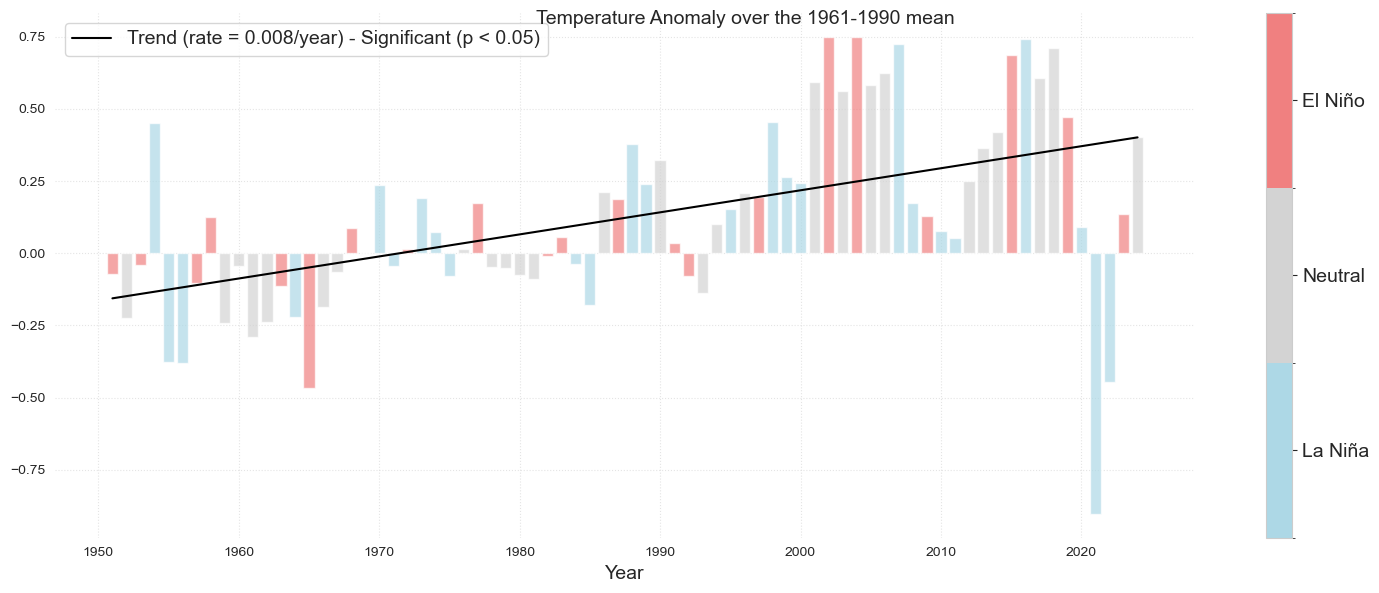

In [12]:
df2 = df1.resample('Y').mean()
fig = plot_bar_probs_ONI(df2, var='tmean_ref')
fig.suptitle('Temperature Anomaly over the 1961-1990 mean', fontsize = fontsize)
glue("fig_ninho", fig, display=False)
plt.show()

```{glue:figure} fig_ninho
:name: "fig_ninho"

Annual mean temperature anomalies relative to 1961–1990 climatology at Koror. The solid black line represents the trend, which is  statistically significant (p < 0.05).  Shading in the bar plots represent El Niño (red), La Niña (blue) and Neutral (grey) phases of ENSO as defined by values of the Oceanic Niño Index (ONI). 

```

In [13]:
df_format = np.round(df1.describe(), 2)

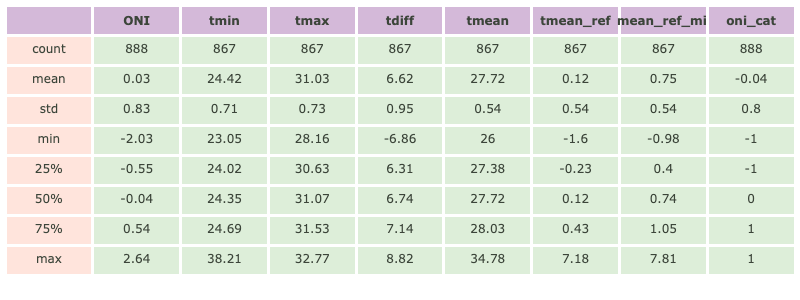

In [14]:
fig = plot_df_table(df_format)
df2img.save_dataframe(fig=fig, filename="getting_started.png")